In [1]:
from collections import OrderedDict

import cv2
import matplotlib.pyplot as plt
import numpy as np
from robotpy_apriltag import AprilTagDetector

from main import get_camera_properties
from utils.apriltags import detect_tags, get_panel, get_altitude_from_panels
from utils.panel import calculate_panel_size_in_pixels


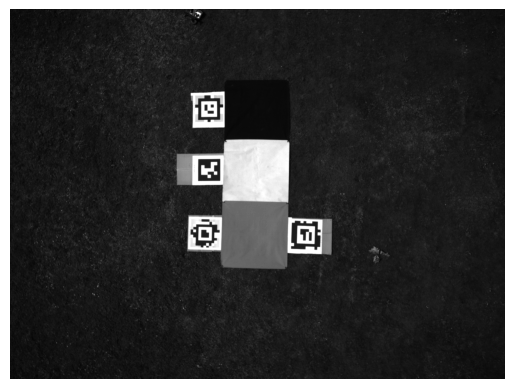

In [2]:
path = "data/example_apriltag_image.tif"
#path = "data/example_apriltag_image_2.tif"
#path = "data/example_apriltag_image_3.tif"
image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
plt.axis('off')
plt.imshow(image, cmap="grey")

In [3]:
from utils.apriltags import get_pose_estimator_config

# Hyperparameters


tag_detection_size_m = np.array([0.28, 0.36, 0.25, 0.31])
tag_total_size_m = np.array([0.5, 0.44, 0.56, 0.56])

panel_size_m = (0.8, 0.8)

# Tag Information
families = ["tagCircle21h7", "tag25h9", "tagCircle49h12", "tagStandard52h13"]
valid_ids = [4]
tag_size = 0.3

estimator_config = get_pose_estimator_config(path, (len(image[0]), len(image)), tag_size)

# Conversions from the detection area width to the total tag width
tag_detection_to_total_size = tag_total_size_m / tag_detection_size_m
tag_detection_to_total_width_conversions = dict(zip(families, tag_detection_to_total_size))

# Sizes of the tags converted to meters 
tag_sizes_in_m = dict(zip(families, zip(tag_detection_size_m, tag_total_size_m)))

In [4]:
from utils.apriltags import get_detector_config

detector = AprilTagDetector()

for family in families:
    detector.addFamily(family)
detector.setConfig(get_detector_config())

In [5]:
def show_tags(img, show_id=False):
    plt.imshow(img, cmap="gray")
    plt.axis("off")

    for tag in detect_tags(img, detector, valid_ids):
        corners = list(tag.getCorners(tuple([0.0] * 8)))
        x, y = corners[::2], corners[1::2]
        # Append the first point to the end to close the rectangle/polygon
        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        plt.plot(x, y)
        plt.scatter(tag.getCenter().x, tag.getCenter().y, marker="o", s=20, label=tag.getFamily())
        if show_id:
            plt.text(tag.getCenter().x + 50, tag.getCenter().y - 50, tag.getId(), color="black", ha="center",
                     va="center",
                     bbox=dict(boxstyle="round",
                               ec=(1., 0.5, 0.5),
                               fc=(1., 0.8, 0.8),
                               ))
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

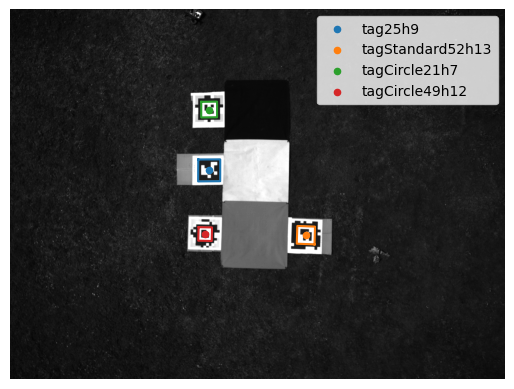

In [6]:
show_tags(image, False)

In [9]:
from utils.polygons import shrink_or_swell_shapely_polygon

import shapely


def show_panels(img):
    plt.axis('off')
    tags = detect_tags(img, detector, valid_ids)
    resolution = (len(image[0]), len(image))
    altitude = get_altitude_from_panels(tags, path, resolution, tag_size) * 1.4
    print(f"Estimated altitude: {altitude:.01f}m")
    properties = get_camera_properties(path)
    panel_size_pixel = calculate_panel_size_in_pixels(altitude, resolution, panel_size_m, *properties)
    print(f"Estimated panel size: {panel_size_pixel[0]:.01f} pixel")
    cmap = plt.get_cmap('viridis')
    colors = cmap(np.linspace(0, 1, len(tags)))
    for tag, color in zip(tags, colors):
        corners = get_panel(tag, panel_size_pixel, resolution, False)
        plt.imshow(img, cmap="grey")

        plt.scatter(tag.getCenter().x, tag.getCenter().y, color=color)

        x, y = zip(*corners)

        # Append the first point to the end to close the rectangle/polygon
        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        plt.plot(x, y, linewidth=1, color=color)

        polygon = shapely.Polygon(corners)
        polygon = shrink_or_swell_shapely_polygon(polygon, 0.2)
        detection_corners = polygon.exterior.coords.xy
        x, y = detection_corners
        x = list(x) + [x[0]]
        y = list(y) + [y[0]]
        plt.plot(x, y, linewidth=1, linestyle="dotted", color=color)
    plt.show()

Estimated altitude: 13.6m
Estimated panel size: 187.0 pixel


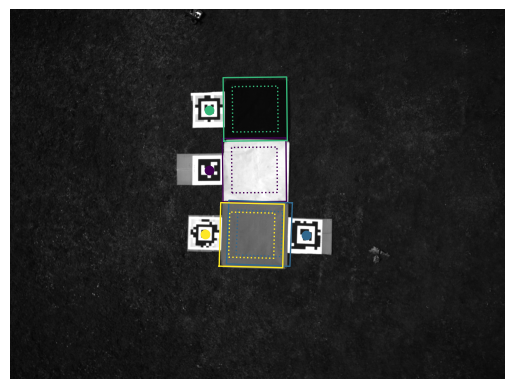

In [10]:
show_panels(image)